# Benchmarks

This jupyter notebook aims at analysing the results obtained in `Main.ipynb`.

The work is based on the dataset `yellow.csv` located in the directory _data/_. (It is possible to regenerate this dataset by using the notebook `Preprocessing.ipynb`.)

`yellow.csv` has been extracted from the data available on the ___NYC Taxi and Limousine Commission (LTC)___ [webpage](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

__Goal__:
The user is a NYC taxi driver who wants to know in the next hours where to drive to maximize his chances to find a client. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import Tools

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

from sklearn.tree import DecisionTreeRegressor

In [2]:
FONT = {'family': 'sans-serif', 'weight': 'normal', 'size': 16}

init_notebook_mode(connected=True)

## 1. Prepare Data

In [3]:
PATH = '../data/' # Modify this to fit your data folder

In [4]:
def convert_to_NYC(df):
    df.timestamp = pd.to_datetime(df.timestamp, utc=True)
    df.set_index('timestamp', drop=True, inplace=True)
    df.index = df.index.tz_convert('America/New_York')
    return df

### 1.1. Retrieve Craft Ai previous results (computed in `Main.ipynb`)

In [5]:
selected_zones = [7, 145, 146, 193, 226]
selected_zones_str = [str(z) for z in selected_zones]

In [6]:
craft = pd.read_csv(PATH + 'craftai.csv')
craft = convert_to_NYC(craft)
craft.head()

,7,145,146,193,226,best_zone
timestamp,,,,,,
2017-12-04 00:00:00-05:00,23.096888,8.190315,12.197233,5.543253,25.476620,226
2017-12-04 01:00:00-05:00,33.562490,9.083334,12.312504,12.635417,39.916680,226
2017-12-04 02:00:00-05:00,41.125010,11.791664,14.031251,16.187498,47.833332,226
2017-12-04 03:00:00-05:00,32.835052,13.854168,18.104166,12.354170,42.145817,226
2017-12-04 04:00:00-05:00,18.979166,15.052089,13.270841,9.437499,20.895832,226


In [7]:
craft_std = pd.read_csv(PATH + 'craftai_std.csv')
craft_std = convert_to_NYC(craft_std)

### 1.2. Prepare the `yellow_` dataset for performance comparison

__Warning !__  `yellow_` is different from the `yellow` dataframe in `Main.ipynb`. `yellow_` is used here to compare Craft AI results with the `DecisionTreeRegressor` from _sklearn_.

In [8]:
yellow_ = pd.read_csv(PATH + 'yellow.csv')
yellow_.columns = yellow_.columns[1:].insert(0, 'timestamp')
yellow_ = convert_to_NYC(yellow_)
yellow_ = yellow_[selected_zones_str]
yellow_['dow'] = yellow_.index.dayofweek
yellow_['hod'] = yellow_.index.hour
yellow_.head()

,7,145,146,193,226,dow,hod
timestamp,,,,,,,
2017-01-01 00:00:00-05:00,66.0,20.0,41.0,13.0,54.0,6,0
2017-01-01 01:00:00-05:00,54.0,15.0,22.0,10.0,39.0,6,1
2017-01-01 02:00:00-05:00,42.0,11.0,16.0,8.0,25.0,6,2
2017-01-01 03:00:00-05:00,26.0,8.0,16.0,8.0,24.0,6,3
2017-01-01 04:00:00-05:00,33.0,7.0,23.0,3.0,27.0,6,4


### 1.3. Split the dataset to create `train` and `test` sets

In [9]:
start = pd.to_datetime('2017-12-04 00:00')
train = yellow_[:start]
test = yellow_[start:pd.to_datetime('2017-12-17 23:00')]

reality = test[selected_zones_str]

### 1.4. Predict with the `DecisionTreeRegressor`

In [10]:
def get_sklearn_DT_pred(zone):
    dt = DecisionTreeRegressor(max_depth=10)
    X = train[['dow', 'hod']]
    y = train[str(zone)]
    dt.fit(X, y)

    return dt.predict(test[['dow', 'hod']])

In [11]:
sklearn = pd.DataFrame(
    [np.array(get_sklearn_DT_pred(z)) for z in selected_zones],
)
sklearn = sklearn.T
sklearn.columns=selected_zones_str
sklearn.index=test.index
sklearn.head()

,7,145,146,193,226
timestamp,,,,,
2017-12-04 00:00:00-05:00,21.714286,5.938776,9.632653,4.938776,19.224490
2017-12-04 01:00:00-05:00,26.687500,8.770833,12.500000,6.916667,29.000000
2017-12-04 02:00:00-05:00,35.562500,9.812500,13.833333,14.645833,43.979167
2017-12-04 03:00:00-05:00,39.187500,12.812500,15.833333,14.854167,45.583333
2017-12-04 04:00:00-05:00,27.812500,14.291667,15.979167,10.479167,35.625000


## 2. Prediction analysis

### 2.1. Time series observation

In [12]:
# To display without timezone shifting
utc_test_index = pd.date_range('2017-12-04 00:00', 
                        "2017-12-17 23:00", freq="h") 

In [13]:
for z in selected_zones_str:
    Tools.plot_zone_results(z, reality, 
                            craft, craft_std, 
                            sklearn, utc_test_index)

### 2.2. RMSE Analysis

In [14]:
def rmse_df(df1, df2):
    return np.sqrt(((df1.subtract(df2))**2).mean(axis=0))


In [15]:
sklearn_rmse = rmse_df(reality, sklearn)
craftai_rmse = rmse_df(reality, craft[selected_zones_str])

In [16]:
rmse_analysis = pd.DataFrame({
    "sklearn": sklearn_rmse,
    "craft-ai": craftai_rmse
})
rmse_analysis

,sklearn,craft-ai
7,7.850721,6.326054
145,7.184935,7.017198
146,6.090691,5.808792
193,3.568742,3.315155
226,7.961268,5.938602


In [17]:
rmse_analysis = pd.DataFrame(
    np.array([sklearn_rmse, craftai_rmse]).T,
    index=selected_zones,
    columns=['sklearn', 'craft_ai']
)
rmse_analysis.index.name='zone'
rmse_analysis['best_algorithm'] = rmse_analysis.apply(lambda r: rmse_analysis.columns[np.argmin(r.values)], axis=1)
rmse_analysis

,sklearn,craft_ai,best_algorithm
zone,,,
7,7.850721,6.326054,craft_ai
145,7.184935,7.017198,craft_ai
146,6.090691,5.808792,craft_ai
193,3.568742,3.315155,craft_ai
226,7.961268,5.938602,craft_ai


### 2.3. Where do algorithms predictions fail ?

In [18]:
def plot_error(df, title='', nb_hours_to_display=24):

    sq_er = (reality.subtract(df))**2
    plot_text = {
        'x_tick_labels': selected_zones,
        'y_tick_labels': sq_er.index[:nb_hours_to_display],
        'title': title,
        'xlabel': 'Zone',
        'ylabel': 'Time',
        'cbar_label': 'Square Error'
    }

    Tools.plot_matshow(sq_er[:nb_hours_to_display], plot_text)

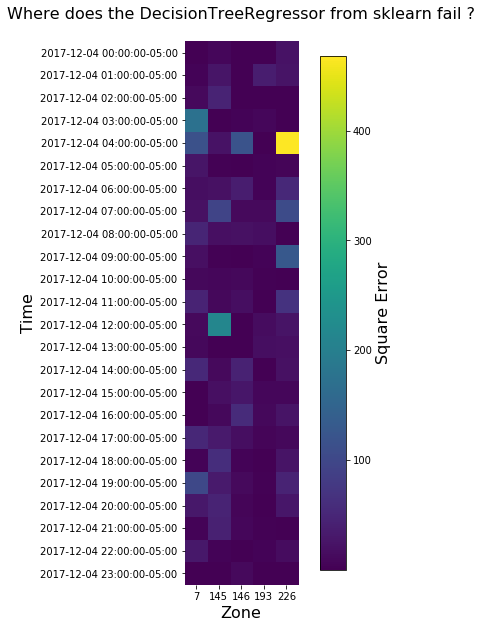

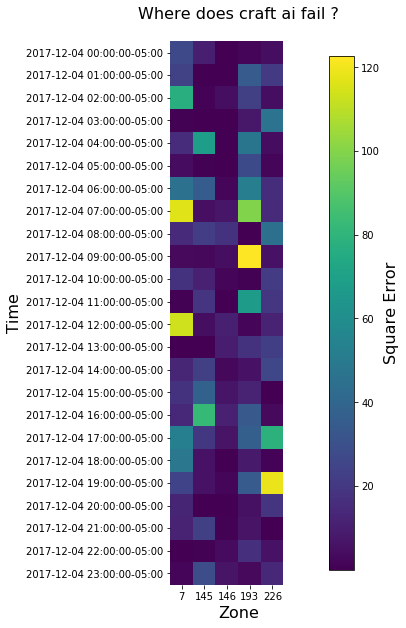

In [19]:
plot_error(sklearn, 'Where does the DecisionTreeRegressor from sklearn fail ?')
plot_error(craft, 'Where does craft ai fail ?')

> One can see that square error scales aren't equal

